# Llava - Large Language and Vision Assistant (based on CLIP and LLama)

See: https://huggingface.co/docs/transformers/main/en/model_doc/llava <br>
Paper: https://arxiv.org/abs/2304.08485

In [1]:
import pandas as pd
# df = pd.read_csv("/content/project1_hallucinations_group5.csv")
# # [20, 21, 25, 40]
# i = 40
image_url = "https://cdn.pixabay.com/photo/2023/11/30/08/36/chhathpuja-8421051_1280.jpg" # df.iloc[i]["image_link"]

In [2]:
from PIL import Image
import requests
import torch
from transformers import (BitsAndBytesConfig, AutoProcessor,
                          LlavaForConditionalGeneration, GenerationConfig)

/anaconda/envs/dpml_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.is_available()

True

In [4]:
def generate(image, prompt, processor, model, temperature=1.0):
    generation_config = GenerationConfig(max_new_tokens=200,
                                         do_sample=True,
                                         temperature=temperature,
                                         output_scores=True,
                                         return_dict_in_generate=True)
    device = model.device
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    generate_outputs = model.generate(**inputs, generation_config=generation_config)
    # we extracted the *scores* of the model, which are after applying the temperature
    # and before the SoftMax. For converting them into logits,
    # we need to multiply them by the temperature.
    generate_outputs['scores'] = [x*temperature for x in generate_outputs['scores']]
    return generate_outputs


def extract_logits(processor, generate_outputs, min_prob=1e-3):
    scores_len = len(generate_outputs['scores'])
    generated_ids = generate_outputs['sequences'].tolist()[0][-scores_len:]
    generated_scores = []
    for i, token_id in enumerate(generated_ids):
        token = processor.tokenizer._convert_id_to_token(token_id).replace("▁", " ")
        logits = torch.softmax(generate_outputs['scores'][i], dim=-1)[0].tolist()
        logits = {t: p for t, p in enumerate(logits) if (p > min_prob or t == token_id)}
        logits = {processor.tokenizer._convert_id_to_token(t).replace("▁", " "): p for t, p in logits.items()}
        generated_scores.append((token, logits))
    generated_text = ''.join([x for x, _ in generated_scores])
    return generated_text, generated_scores

In [5]:
def generate_probe_pred(image, prompt, processor, model, temperature=1.0):
    generation_config = GenerationConfig(max_new_tokens=200,
                                         do_sample=True,
                                         temperature=temperature,
                                         output_scores=False,
                                         return_dict_in_generate=False)
    device = model.device
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    generate_outputs = model.generate(**inputs, generation_config=generation_config)
    decoded_output = processor.tokenizer.decode(generate_outputs[0], skip_special_tokens=True).split("ASSISTANT:")[1]
    return decoded_output

In [6]:
model_name = 'llava-hf/llava-1.5-7b-hf'
quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.bfloat16)

model = LlavaForConditionalGeneration.from_pretrained(model_name,
                                                      quantization_config=quantization_config)
processor = AutoProcessor.from_pretrained(model_name)

/anaconda/envs/dpml_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.45s/it]
/anaconda/envs/dpml_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


USER: <image>
Please provide a thorough description of this image
ASSISTANT:


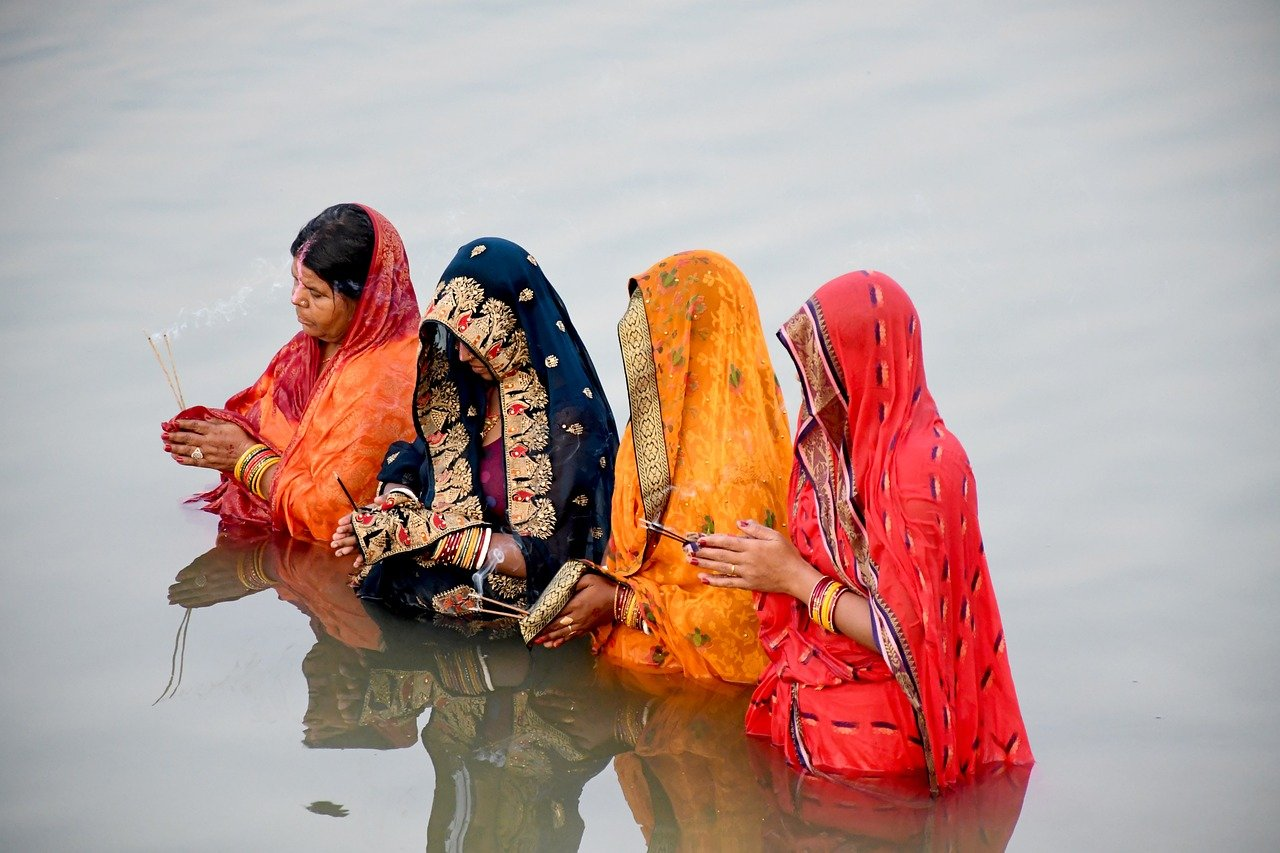

In [7]:
image = Image.open(requests.get(image_url, stream=True).raw)
instruction = "Please provide a thorough description of this image"
prompt = f"USER: <image>\n{instruction}\nASSISTANT:"
print(prompt)
image

## Hallucinations

The image shows a young woman with red hair, standing near a large group of children. The woman is holding a little girl close to her. They all appear to be gathered together in a grassy field or in the woods. [All] the individuals in the group are wearing grey clothes. There is a mix of girls and boys among them, creating a diverse and lively scene.</s>


In [145]:
hallucinations = """The image showcases a man riding a bicycle on the beach, with a [backpack] strapped to the back of the bicycle. The rider has a hat on, suggesting a relaxed atmosphere. There is another cyclist further back, and a few other people in the distance, all enjoying the beach setting.<0x0A><0x0A>In addition to the main cyclist, there is also a [handbag]visible in the scene, probably belonging to one of the beachgoers. Another bicycle can be seen on the left side of the image. The entire scene gives off a sense of leisure and exploration.</s>"""

## Hedges

The image shows a young woman with red hair, standing near a large group of children. The woman is holding a little girl close to her. They all [appear to be] gathered together in a grassy field or in the woods. All the individuals in the group are wearing grey clothes. There is a mix of girls and boys among them, creating a diverse and lively scene.</s>



In [159]:
hedges = """The image shows a young woman with red hair, standing near a large group of children. The woman is holding a little girl close to her. They all [appear to be] gathered together in a grassy field or in the woods. All the individuals in the group are wearing grey clothes. There is a mix of girls and boys among them, creating a diverse and lively scene.</s>"""

In [8]:
generate_outputs = generate(image, prompt, processor, model, temperature=0.9)
generated_text, generated_logits = extract_logits(processor, generate_outputs, min_prob=1e-3)

logits = []
for token, tokens_dict in generated_logits:
  logits.append(tokens_dict)

In [9]:
print(generated_text)
print(logits)

 The image captures four women sitting in a river. They are positioned from left to right side of the scene. Each woman is wearing a flower print pink dress, which adds color contrast to the natural surroundings.<0x0A><0x0A>Both women on the left side are wearing white pearl necklaces, while it is unclear if the women on the right side are wearing necklaces as well. The scene conveys a peaceful and relaxing atmosphere, likely a bonding moment among these women.</s>
[{' A': 0.004251791629940271, ' The': 0.876086950302124, ' In': 0.10301166772842407, ' This': 0.009001042693853378, ' There': 0.0015160257462412119, ' Four': 0.002619452541694045, ' Three': 0.0015398967079818249}, {' image': 0.888800859451294, ' picture': 0.0014448394067585468, ' scene': 0.10615232586860657, ' photo': 0.0014907035510987043}, {' is': 0.013701315969228745, ' dep': 0.2211284339427948, ' show': 0.04220302402973175, ' port': 0.0685022696852684, ' shows': 0.14962270855903625, ' capt': 0.09510615468025208, ' featur

In [160]:
probes =  [
"There is a young woman with red hair",
"All the children are wearing grey clothes",
"There is a mix of girs and boys in the image",
"The woman is standing"
]

labels = ["true", "false", "true", "true"]
preds = []
for probe in probes:
  prompt = f"USER: <image>\nAccording to the image, is the following sentence correct? answer yes/no only: {probe}\nASSISTANT:"
  answer = generate_probe_pred(image, prompt, processor, model, temperature=0.9)
  if "Yes" in answer:
    preds.append("true")
  else:
    preds.append("false")
  print(f"{probe}: {answer}\n")

There is a young woman with red hair:  Yes

All the children are wearing grey clothes:  Yes

There is a mix of girs and boys in the image:  Yes

The woman is standing:  Yes



In [161]:
context1 = """T[he image shows a young woman with red hair], standing near a large group of children. The woman is holding a little girl close to her. They all appear to be gathered together in a grassy field or in the woods. All the individuals in the group are wearing grey clothes. There is a mix of girls and boys among them, creating a diverse and lively scene.</s>"""
context2 = """The image shows a young woman with red hair, standing near a large group of children. The woman is holding a little girl close to her. They all appear to be gathered together in a grassy field or in the woods. [All the individuals in the group are wearing grey clothes]. There is a mix of girls and boys among them, creating a diverse and lively scene.</s>"""
context3 = """The image shows a young woman with red hair, standing near a large group of children. The woman is holding a little girl close to her. They all appear to be gathered together in a grassy field or in the woods. All the individuals in the group are wearing grey clothes. [There is a mix of girls and boys among them], creating a diverse and lively scene.</s>"""
context4 = """The image shows [a young woman with red hair, standing] near a large group of children. The woman is holding a little girl close to her. They all appear to be gathered together in a grassy field or in the woods. All the individuals in the group are wearing grey clothes. There is a mix of girls and boys among them, creating a diverse and lively scene.</s>"""

contexts = [context1, context2, context3, context4]

In [162]:
row = {
    'image_link': image_url,
    'temperature': '0.9',
    'description': generated_text,
    'logits': logits,
    'hallucinations': hallucinations,
    'hedges': hedges,
    'probe_1': probes[0],
    'label_1': labels[0],
    'pred_1': preds[0],
    'context_1': contexts[0],
    'probe_2': probes[1],
    'label_2': labels[1],
    'pred_2': preds[1],
    'context_2': contexts[1],
    'probe_3': probes[2],
    'label_3': labels[2],
    'pred_3': preds[2],
    'context_3': contexts[2],
    'probe_4': probes[3],
    'label_4': labels[3],
    'pred_4': preds[3],
    'context_4': contexts[3],
}

In [163]:
row_df = pd.DataFrame([row])
res_df = pd.read_excel("/content/result1.xlsx", index_col=0)
update_df = pd.concat([res_df, row_df])
update_df.astype(str).to_excel('result1.xlsx')
# row_df.astype(str).to_excel('result.xlsx')

In [126]:
a = set(update_df['image_link'])
b = set(df['image_link'])

In [129]:
images = list(b - a)
df[df['image_link'].isin(images)].index

Index([13, 20, 21, 25, 40], dtype='int64')

In [ ]:
print("Description")
print(generated_text)
print("Logits")
print(logits)
print("Hedges")
print(hedges)
print("probe1")
print(probes[0])
print("label", labels[0])
print("pred", preds[0])
print("context", context1)
print("probe2")
print(probes[1])
print("label", labels[1])
print("pred",preds[1])
print("context", context2)
print("probe3")
print(probes[2])
print("label", labels[2])
print("pred",preds[2])
print("context", context3)
print("probe4")
print(probes[3])
print("label", labels[3])
print("pred",preds[3])
print("context", context4)

Description
 The image features three people, each holding a red ball or sports ball. Two of the individuals are standing, while a woman is sitting with a blissful smile. A pair of red sneakers is also visible in the scene. The scene takes place on what appears to be a black background, possibly indicating that this is a promotional or photography shoot. The three individuals are enjoying the activity and sharing a joyful moment together.</s>
Logits
[{' A': 0.0074281408451497555, ' The': 0.806557834148407, ' In': 0.16906403005123138, ' This': 0.007545116823166609, ' There': 0.002648585010319948, ' Three': 0.004505395423620939}, {' image': 0.9310309290885925, ' picture': 0.0017973125213757157, ' scene': 0.062375180423259735, ' photo': 0.002495325868949294}, {' is': 0.013429689221084118, ' dep': 0.12544190883636475, ' show': 0.07036667317152023, ' port': 0.04687422141432762, ' shows': 0.17145876586437225, ' capt': 0.06610336899757385, ' features': 0.4378361701965332, ' consists': 0.00205